In [42]:
# basic imports
import pandas as pd, matplotlib.pyplot as plt, numpy as np 
import IPython.display as ipd

In [43]:
# librosa - for CQT and visualisation
import librosa, librosa.display

In [44]:
# Interval for label storage
from intervaltree import Interval,IntervalTree

In [64]:
from IPython.display import SVG, Image

# Neural Network Grid Search

## Outline

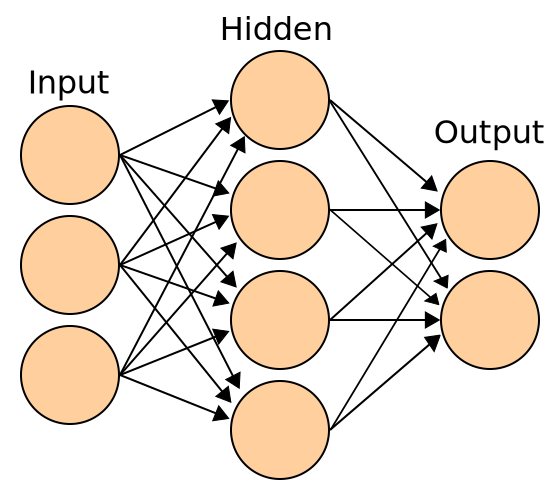

In [65]:
SVG('Artificial_neural_network.svg')

We will make use of a neural network to help with automatic music transcription. We will train the model with a STFT array and the ground truth annotations for the music piece. Essentially for each frame in the audio signal we a CQT transform with 252 bins and a corresponding binary labels array of length 88.

**TYPE OF PROBLEM** - This type of problem is known a multi-label classification problem.

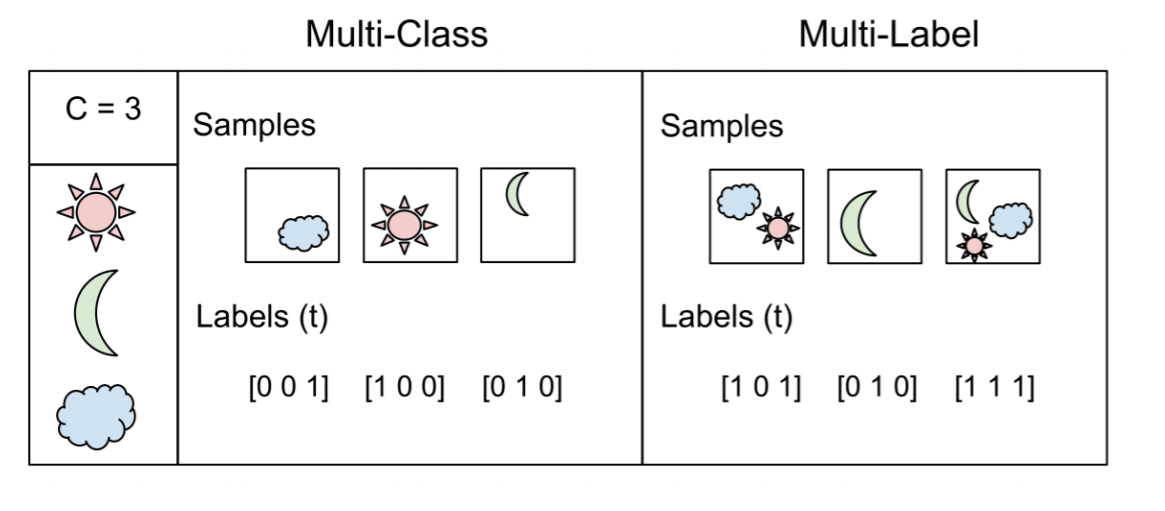

In [66]:
Image('multi-label.png')

**INPUT**
- The input to the model is a Constant Q Transform (CQT) of the music data for each song. We are making use of a CQT because the frequency resolution in the lower ranges is better then a traditional STFT. The dimensions of the input array are determined by the number of frames and the number of bins/features of the CQT.

**OUTPUT**
- the output for each frame is a vector with 88 elements corresponding to the notes on a piano. A binary value of 1 corresponds to the note being active
- we will train the model on ground truth annotations

**GOAL** 
- to learn the weights by fitting the model to the data and optimizing the loss function 

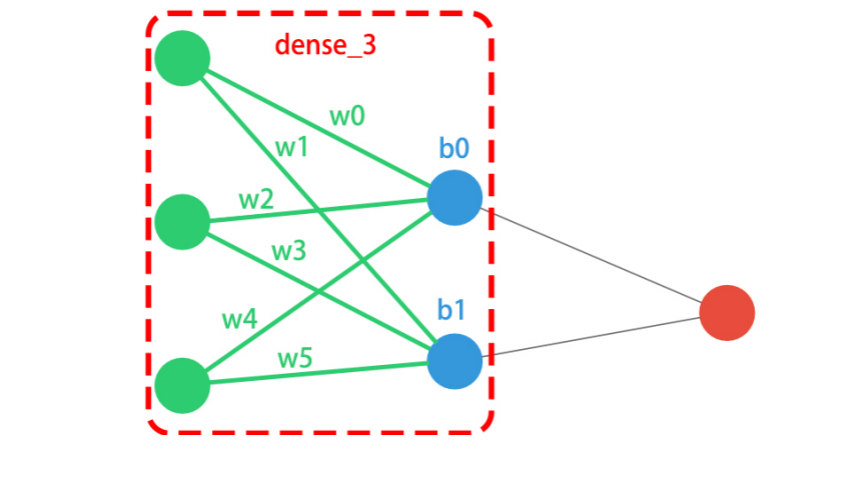

In [68]:
Image('nn_params.png')

**HYPER PARAMETERS TO TUNE** 
- Activation functions (tanh, relu etc.) 
- number of neurons per layer 
- batch size (stochastic, mini-batch, batch)
- optimizer of choice (adam,sgd,ada etc.)
- loss function for back propagation (binary cross entropy, mean squared error)
- number of layers 
- batch normalization (reduces problems with activation functions)
- dropout rates

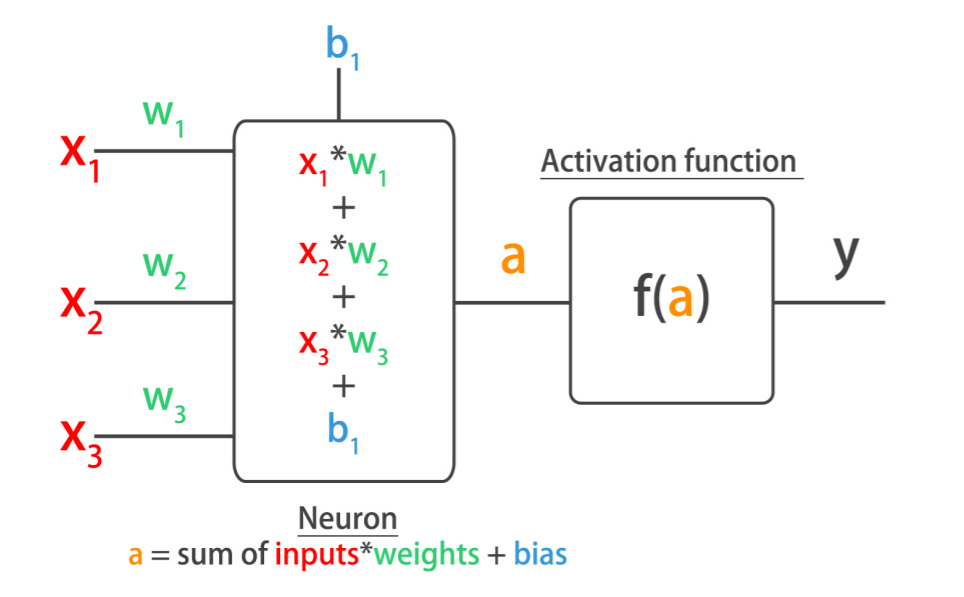

In [67]:
Image('activation_function.png')

## Import data

In [45]:
# import h5py to read in hdf5 files 
import h5py

filename ='musicnet.h5'
music_net = h5py.File(filename,'r')
type(music_net)

h5py._hl.files.File

In [46]:
# we will use 1 songs for hyper parameter tuning 
# extract the 10th song from the database
n = 10
# make sure its a vector
source_list = list(music_net.keys())[n:n+1]
source_list

['id_1750']

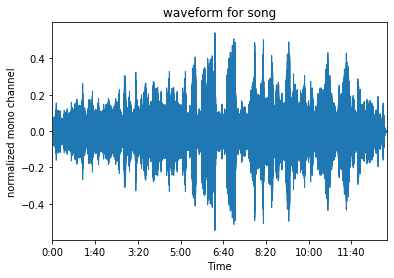

In [47]:
# plot the audio data for the first song 
librosa.display.waveplot(music_net[source_list[0]]['data'][()],
                         sr=44100,
                         x_axis= 'time');
plt.ylabel('normalized mono channel');
plt.title('waveform for song');

## Preprocessing

In [48]:
# init lists for storing results
cqt_container = [] # array to store the cqt for each song
cqt_shapes = [] # array to store the shapes of each cqt

print('initializing cqt transforms')
print('-'*60)
for id_ in source_list:
    print('extracting data from',id_)
    # extract the mono audio data and labels
    song = music_net[id_]
    music = song['data'][()]

    # downsampling
    sr = 44100
    sr_16k = 16000

    # resample to 16kHz to increase the the number of cqt points
    music = librosa.resample(music,sr,sr_16k)

    # CQT parameters
    sr_16k = sr_16k # downsampling to 16kHz
    hop_length = 512 # 32ms frames  
    bins_per_octave = 36 # corresponds to 7 octaves on the piano 
    # 7 x 36 = 252 number of bins 
    n_bins = 252 # frequency resolution 
    window = 'hann' # hanning window for smoothness

    # CQT absolute magnitude 
    C = np.abs(librosa.cqt(music,
                           sr = sr_16k , 
                           hop_length = hop_length,
                           bins_per_octave = bins_per_octave,
                           window = window,
                           n_bins = n_bins))
    # transpose to get the array in the correct format
    C = np.transpose(C)
    
    # append the length of this cqt to the length array 
    cqt_shapes.append(C.shape)
    
    # append to container
    cqt_container.append(C)

print('-'*60)
print('CQT transformation on each song complete')
print('-'*60)
print('CQT dimensions:', cqt_shapes)

initializing cqt transforms
------------------------------------------------------------
extracting data from id_1750
------------------------------------------------------------
CQT transformation on each song complete
------------------------------------------------------------
CQT dimensions: [(24506, 252)]


In [49]:
# extract and format labels 
labels_container = [] # array to store the labels of each song
labels_shapes = [] # array for storing label dimensions

# set up params for labels 
number_of_notes = 88 ## 88 piano notes 
hop_length = 512 # 32ms frames  
# counter to loop through cqt container 
i = 0 

print('constructing label vectors')
print('-'*60)

for id_ in source_list:
    # retrieve the song for this id 
    song = music_net[id_]
    raw_labels = song['labels'][()]
    
    # number of frames in this song
    number_frames = cqt_container[i].shape[0]
    i += 1  
    
    # binary labels - one hot encoding
    binary_labels = np.zeros((number_frames, number_of_notes))

    # init tree for slicing
    labels_tree = IntervalTree()
    # construct interval tree 
    for label in raw_labels: 
        pitch = label['note_id']
        start_time = label['start_time']
        end_time = label['end_time']
        labels_tree.addi(start_time,end_time,pitch)

    # resample the labels by finding the number of frames per second
    for frame in range(binary_labels.shape[0]):
        # slice the interval tree for notes in this frame 
        labels = labels_tree.at(frame*hop_length)
        for label in labels:
            # the labels vector is from 0 to 87 
            # 21 is the A0 on the piano
            pitch = label[2]-21 
            # if this pitch is active in this window 
            binary_labels[frame,pitch] = 1
    
    # append the binary_labels
    labels_container.append(binary_labels)
    # store label shapes 
    labels_shapes.append(binary_labels.shape)

print('labels preprocessed')
print('-'*60)
print('labels dimensions:', labels_shapes)

constructing label vectors
------------------------------------------------------------
labels preprocessed
------------------------------------------------------------
labels dimensions: [(24506, 88)]


In [50]:
# Format the data for the model 
X = np.vstack(cqt_container)
y = np.vstack(labels_container)

## Hyperparameter tuning for DNN

In [51]:
# model definition  
from keras.layers import Dense, Dropout
from keras.models import Sequential 
import keras.optimizers as KO
from keras.layers import BatchNormalization

# default hyperparameters for model
layers = 3 # layers of model 
nn = 256 # nodes
lr = 0.001 # learning rate
act ='relu' # activation functions
drop = 0 # dropout rate to improve test error perf

# default static parameters
num_col = 252 # inputs 
output_nodes = 88 # outputs 
loss = 'binary_crossentropy' # loss function for use in back propagation

# define model with params
def create_model(layers=layers,nn=nn,lr=lr,act=act, drop=drop ,loss=loss):  
  # Create an Adam optimizer with the given learning rate
  opt = KO.Adam(lr=lr)
  # create model 
  model = Sequential()
  # input layer
  model.add(Dense(num_col,kernel_initializer='normal', 
                  activation=act ,input_shape=(num_col,)))
  model.add(Dropout(drop))
  model.add(BatchNormalization())
    
  for i in range(layers):
    # layers with dropout and batch normalization 
    model.add(Dense(nn, activation=act,
                    kernel_initializer = 'normal'))
    model.add(Dropout(drop))
    model.add(BatchNormalization())
  
  # output layer - we require a sigmoid activation function 
  model.add(Dense(output_nodes, activation='sigmoid',kernel_initializer='normal'))
    
  # compile model
  model.compile(optimizer=opt,
              loss=loss,
              metrics=['acc'])
    
  return model

In [52]:
# Import KerasClassifier from keras wrappers
from keras.wrappers.scikit_learn import KerasClassifier # wrapper for NN 
from sklearn.model_selection import RandomizedSearchCV # randomized grid search
from sklearn.model_selection import KFold # cross fold validations
from keras import losses # for defining losses 
from keras import backend as K # for activations
import keras.optimizers as KO # for optimizers
import keras.layers as KL # for leakyRELU 

# Create a KerasClassifier
model = KerasClassifier(build_fn=create_model)

# Define the parameters to try out
params = {'lr' : [0.01,0.001], 
          'act':['selu', 'relu','tanh'], 
          'batch_size':[100,200,400], 
          'layers' : [2,3,4],
          'nn' : [128,256],
          'drop': [0.1,0.2]
         }

# Create a randomize search cv object and fit it on the data to obtain the results
n_iter =  10 # number of combinations to try

random_search = RandomizedSearchCV(model,
                                   param_distributions=params,
                                   cv=KFold(3),
                                   n_iter=n_iter)

print('performing hyperparameter grid search')
print('grab a coffee this will take while...')
print('-'*60)

# fit the RandomizedSearchCV object
# investigating other params so epochs is not the main concern
epochs = 10
results = random_search.fit(X,y,verbose=0, epochs=epochs)
print('-'*60)
print('grid search complete')

performing hyperparameter grid search
grab a coffee this will take while...
------------------------------------------------------------
8168/8168 [==============================] - 5s 638us/step
------------------------------------------------------------
grid search complete


In [55]:
# print the results 
print('Best: {} using {}'.format(results.best_score_,
                                 results.best_params_))

Best: 0.9640322588447998 using {'nn': 128, 'lr': 0.001, 'layers': 3, 'drop': 0.2, 'batch_size': 200, 'act': 'selu'}


In [56]:
# display output of grid search in a dataframe 
df_results = pd.DataFrame(results.cv_results_)
df_results_concise = df_results[['rank_test_score','mean_test_score',
                                 'param_nn', 'param_lr', 'param_layers', 'param_drop','param_batch_size', 'param_act']].sort_values(by='rank_test_score')
df_results_concise

,rank_test_score,mean_test_score,param_nn,param_lr,param_layers,param_drop,param_batch_size,param_act
8,1,0.964032,128,0.001,3,0.2,200,selu
3,2,0.962289,256,0.001,4,0.1,400,relu
5,3,0.960818,128,0.001,3,0.1,200,selu
9,4,0.960332,128,0.001,3,0.1,200,relu
1,5,0.957442,128,0.001,4,0.1,100,relu
0,6,0.956409,128,0.01,2,0.2,400,selu
7,7,0.955196,128,0.01,2,0.1,400,relu
4,8,0.954245,256,0.01,2,0.1,100,selu
6,9,0.954056,128,0.01,2,0.1,200,selu
2,10,0.950962,128,0.01,4,0.1,400,selu


In [57]:
best_parameters = df_results_concise.iloc[0,:]
best_parameters

rank_test_score            1
mean_test_score     0.964032
param_nn                 128
param_lr               0.001
param_layers               3
param_drop               0.2
param_batch_size         200
param_act               selu
Name: 8, dtype: object

## Define best model - multilabel architecture

In [59]:
# best parameters for model
layers = 3
nn = 128 
lr = 0.001 
act ='selu'
drop = 0.2 

# define model with best params from grid search to apply to unseen data
model = create_model(layers=layers,
                     nn=nn,
                     lr=lr,
                     act=act,
                     drop=drop); 

# summary for model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_300 (Dense)            (None, 252)               63756     
_________________________________________________________________
dropout_211 (Dropout)        (None, 252)               0         
_________________________________________________________________
batch_normalization_237 (Bat (None, 252)               1008      
_________________________________________________________________
dense_301 (Dense)            (None, 128)               32384     
_________________________________________________________________
dropout_212 (Dropout)        (None, 128)               0         
_________________________________________________________________
batch_normalization_238 (Bat (None, 128)               512       
_________________________________________________________________
dense_302 (Dense)            (None, 128)               16512     
__________